In [7]:
import pandas as pd
import copy
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import tqdm.notebook as tq
import scipy.cluster.hierarchy as spc
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.feature_selection import VarianceThreshold
from tqdm import tqdm
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split as tts, cross_val_score as cv, RepeatedStratifiedKFold as rsk
from sklearn.ensemble import RandomForestClassifier as rf, ExtraTreesClassifier as et, BaggingClassifier as bc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score,make_scorer
from sklearn.utils import class_weight
import lightgbm as lgb

# EDA 

In [65]:
train_df = pd.read_csv("train.csv")

In [66]:
test_df = pd.read_csv("test.csv")
len(test_df)

23856

In [67]:
train_df.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [68]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [69]:
# Columns with Nan
train_df.loc[:, train_df.isna().any()].head()

,v2a1,v18q1,rez_esc,meaneduc,SQBmeaned
0,190000.0,NaN,NaN,10.0,100.0
1,135000.0,1.0,NaN,12.0,144.0
2,NaN,NaN,NaN,11.0,121.0
3,180000.0,1.0,1.0,11.0,121.0
4,180000.0,1.0,NaN,11.0,121.0


In [70]:
nan_rows = train_df.shape[0] - train_df.dropna().shape[0]
print(f"there are {nan_rows} rows that have nan values")

there are 9401 rows that have nan values


In [71]:
feature_description = pd.read_csv("codebook.csv").set_index("Variable name")

## Target

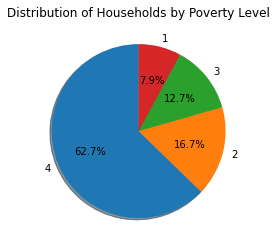

In [72]:
plt.pie(train_df['Target'].value_counts().values,labels=train_df['Target'].value_counts().index,autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title("Distribution of Households by Poverty Level")
plt.show()

In [ ]:
train_df['Target'].value_counts()

In [ ]:
target_corr = train_df.corr()['Target'].sort_values()

In [ ]:
plt.figure(figsize=(18,12))
plt.bar(target_corr.index[:30], target_corr.values[:30], color ='maroon',width = 0.4)
plt.xticks(rotation=90,fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=(18,12))
plt.bar(target_corr.index[-30:-2], target_corr.values[-30:-2], color ='maroon',width = 0.4)
plt.xticks(rotation=90,fontsize=16)
plt.show()

In [ ]:
plt.figure(figsize=(18,12))
target_corr_absolute  = abs(target_corr).sort_values(ascending=False)[1:]
plt.bar(target_corr_absolute.index[:30], target_corr_absolute.values[:30], color ='maroon',width = 0.4)
plt.xticks(rotation=90,fontsize=16)
plt.title("Feature Corr with target")
plt.show()

In [ ]:
target_corr_absolute  = abs(target_corr).sort_values(ascending=False)[1:]
feature_description.loc[target_corr_absolute.index]

### Fixing Target Value

In [15]:
d={}
weird=[]
for row in train_df.iterrows():
    idhogar=row[1]['idhogar']
    target=row[1]['Target']
    if idhogar in d:
        if d[idhogar]!=target:
            weird.append(idhogar)
    else:
        d[idhogar]=target

In [16]:
for i in set(weird):
    hhold=train_df[train_df['idhogar']==i][['idhogar', 'parentesco1', 'Target']]
    target=hhold[hhold['parentesco1']==1]['Target'].tolist()[0]
    for row in hhold.iterrows():
        idx=row[0]
        if row[1]['parentesco1']!=1:
            train_df.at[idx, 'Target']=target

In [17]:
train_df.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


### Replacing variable names with description for greater understandability 

In [73]:
# train_df = pd.read_csv("train.csv")

In [74]:
# feature_description
# feature_acronym = feature_description.index
# feature_detailed = feature_description.values
# feature_acronym

In [75]:
column_headers = list(train_df.columns)
#to move household identifier to the front
column_headers.remove('idhogar')
column_headers_original = ['idhogar'] + column_headers

train_df = train_df.loc[:,column_headers_original]
column_headers_original.remove('Id')
column_headers_original.remove('Target')
column_headers_new = list(feature_description.loc[column_headers_original]['Variable description'])
column_headers_new.insert(1,'Id')
column_headers_new.append('Target')

In [76]:
train_df.columns = column_headers_new
# column_headers_new

In [77]:

train_df.head()

,Household level identifier,Id,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 has toilet in the household,=1 if the household has refrigerator,owns a tablet,number of tablets household owns,...,escolari squared,age squared,hogar_total squared,edjefe squared,hogar_nin squared,overcrowding squared,dependency squared,meaned squared,Age squared,Target
0,21eb7fcc1,ID_279628684,190000.0,0,3,0,1,1,0,NaN,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,0e5d7a658,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,2c7317ea8,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,2b58d945f,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,2b58d945f,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [78]:
# train_df.to_csv('train_df_renamed.csv', index=False)

## Feature analysis

In [24]:
test_df = pd.read_csv('test_df_renamed.csv')

([<matplotlib.patches.Wedge at 0x1308e0ca0>,
 [Text(-0.9047628507813448, -0.6256230365371901, '0'),
  Text(0.9047627922062851, 0.6256231212471984, '1')],
 [Text(-0.4935070095170971, -0.3412489290202855, '69.3%'),
  Text(0.4935069775670645, 0.3412489752257446, '30.7%')])

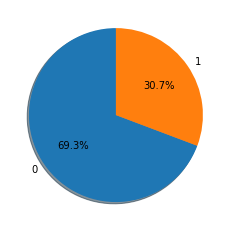

In [25]:
hh_head_test = test_df['=1 if household head'].value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(hh_head_test.values, labels=hh_head_test.index, autopct='%1.1f%%',
        shadow=True, startangle=90)

([<matplotlib.patches.Wedge at 0x1306fe070>,
 [Text(-0.9118828926281061, -0.6151988216277713, '0'),
  Text(0.9118828926281058, 0.6151988216277716, '1')],
 [Text(-0.4973906687062396, -0.3355629936151479, '68.9%'),
  Text(0.4973906687062395, 0.33556299361514813, '31.1%')])

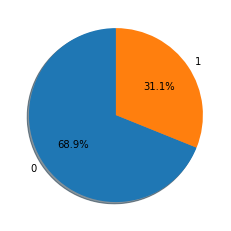

In [26]:
train_df = pd.read_csv('train_df_renamed.csv')

hh_head_train = train_df['=1 if household head'].value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(hh_head_train.values, labels=hh_head_train.index, autopct='%1.1f%%',
        shadow=True, startangle=90)

In [ ]:
fig, ax = plt.subplots(10, 5,figsize=(15,20))
j=0
for i in tq.tqdm(range(50)):
    if ((i+1)/5)>j+1:
        j+=1
#     print(f"j is {j} and i is {i} and division is {i%5}")
    ax[j,i%5].hist(train_df.iloc[:,i+1])
    ax[j,i%5].set_title(train_df.iloc[:,i+1].name)
fig.tight_layout(pad=1.0)

In [ ]:
# fig, ax = plt.subplots(10, 5,figsize=(15,20))
# j=0
# for i in tq.tqdm(range(50,100)):
#     if ((i+1-50)/5)>j+1:
#         j+=1
#     if i==94:
#         pass
# #     print(f"j is {j} and i is {i} and division is {i%5}")
#     ax[j,i%5].hist(train_df.iloc[:,i+1])
#     ax[j,i%5].set_title(train_df.iloc[:,i+1].name)
# fig.tight_layout(pad=1.0)

In [ ]:
  # more options can be specified also

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(train_df.head())

### Filling nan values

In [32]:
train_df.loc[:, train_df.isna().any()].head()

""
0
1
2
3
4


#### 	Monthly rent payment	

In [33]:
train_df[train_df["Monthly rent payment"].isna()]

,Household level identifier,Id,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 has toilet in the household,=1 if the household has refrigerator,owns a tablet,number of tablets household owns,...,escolari squared,age squared,hogar_total squared,edjefe squared,hogar_nin squared,overcrowding squared,dependency squared,meaned squared,Age squared,Target


In [34]:
["=1 own and fully paid house", "=1 own, paying in installments", "=1 rented", "=1 precarious", "=1 other(assigned, borrowed)"]

['=1 own and fully paid house',
 '=1 own, paying in installments',
 '=1 rented',
 '=1 precarious',
 '=1 other(assigned, borrowed)']

In [35]:
train_df.loc[train_df[train_df["=1 own and fully paid house"]==1].index,"Monthly rent payment"]  = train_df[train_df["=1 own and fully paid house"]==1]["Monthly rent payment"].fillna(0.0)

Not paying rent as they own the house

In [36]:
train_df[train_df["=1 own and fully paid house"]==1]

,Household level identifier,Id,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 has toilet in the household,=1 if the household has refrigerator,owns a tablet,number of tablets household owns,...,escolari squared,age squared,hogar_total squared,edjefe squared,hogar_nin squared,overcrowding squared,dependency squared,meaned squared,Age squared,Target
2,2c7317ea8,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,...,121,8464,1,0,0,0.250000,64.0000,121.0000,8464,4
13,c51f9c774,ID_064b57869,0.0,0,4,0,1,1,1,1.0,...,16,6241,4,0,0,1.000000,1.0000,90.2500,6241,4
14,c51f9c774,ID_5c837d8a4,0.0,0,4,0,1,1,1,1.0,...,225,1521,4,0,0,1.000000,1.0000,90.2500,1521,4
26,1e84a2ac8,ID_e5cdba865,0.0,0,5,0,1,1,0,0.0,...,225,1936,1,225,0,0.250000,0.0000,225.0000,1936,4
32,cb6bb28dd,ID_e24d9c3c9,0.0,0,5,0,1,1,0,0.0,...,1,784,25,121,1,2.777778,0.0625,27.5625,784,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9542,e87e70c06,ID_fc386a944,0.0,0,3,0,0,0,0,0.0,...,9,100,25,4,9,6.250000,2.2500,16.0000,100,2
9543,e87e70c06,ID_2f8268634,0.0,0,3,0,0,0,0,0.0,...,36,169,25,4,9,6.250000,2.2500,16.0000,169,2
9544,e87e70c06,ID_4c180d79f,0.0,0,3,0,0,0,0,0.0,...,36,1089,25,4,9,6.250000,2.2500,16.0000,1089,2
9550,212db6f6c,ID_90a399a51,0.0,0,3,0,1,1,0,0.0,...,36,3721,4,0,0,4.000000,1.0000,9.0000,3721,2


=1 own, paying in installments

In [37]:
train_df[train_df['=1 own, paying in installments']==1].isna().any()

Household level identifier           False
Id                                   False
Monthly rent payment                 False
=1 Overcrowding by bedrooms          False
 number of all rooms in the house    False
                                     ...  
overcrowding squared                 False
dependency squared                   False
meaned squared                       False
Age squared                          False
Target                               False
Length: 141, dtype: bool

=1 rented

In [38]:
train_df[train_df['=1 rented']==1].isna().any()

Household level identifier           False
Id                                   False
Monthly rent payment                 False
=1 Overcrowding by bedrooms          False
 number of all rooms in the house    False
                                     ...  
overcrowding squared                 False
dependency squared                   False
meaned squared                       False
Age squared                          False
Target                               False
Length: 141, dtype: bool

=1 precarious

In [39]:
train_df[train_df['=1 precarious']==1]

,Household level identifier,Id,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 has toilet in the household,=1 if the household has refrigerator,owns a tablet,number of tablets household owns,...,escolari squared,age squared,hogar_total squared,edjefe squared,hogar_nin squared,overcrowding squared,dependency squared,meaned squared,Age squared,Target
245,ece1115ac,ID_694d4b0ce,0.0,0,3,0,1,1,0,0.0,...,9,4225,4,0,0,4.00,1.00,20.25,4225,4
246,ece1115ac,ID_db3aa162f,0.0,0,3,0,1,1,0,0.0,...,36,1600,4,0,0,4.00,1.00,20.25,1600,4
247,fabb02be9,ID_92729a397,0.0,0,4,0,1,0,0,0.0,...,0,2025,9,36,0,2.25,0.00,4.00,2025,4
248,fabb02be9,ID_d61734d32,0.0,0,4,0,1,0,0,0.0,...,36,3481,9,36,0,2.25,0.00,4.00,3481,4
249,fabb02be9,ID_f1791bbeb,0.0,0,4,0,1,0,0,0.0,...,0,1764,9,36,0,2.25,0.00,4.00,1764,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9237,6ce0784a9,ID_c128541ee,0.0,0,4,0,1,1,0,0.0,...,4,64,25,121,9,6.25,2.25,72.25,64,4
9238,6ce0784a9,ID_5b75bcf1c,0.0,0,4,0,1,1,0,0.0,...,49,196,25,121,9,6.25,2.25,72.25,196,4
9239,6ce0784a9,ID_3bf2c6cff,0.0,0,4,0,1,1,0,0.0,...,36,961,25,121,9,6.25,2.25,72.25,961,4
9240,6ce0784a9,ID_6d6a0b868,0.0,0,4,0,1,1,0,0.0,...,121,576,25,121,9,6.25,2.25,72.25,576,4


Assigned and Borrowed

In [40]:
train_df[train_df['=1 other(assigned, borrowed)']==1]

,Household level identifier,Id,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 has toilet in the household,=1 if the household has refrigerator,owns a tablet,number of tablets household owns,...,escolari squared,age squared,hogar_total squared,edjefe squared,hogar_nin squared,overcrowding squared,dependency squared,meaned squared,Age squared,Target
186,322cefd2f,ID_6274a9721,0.0,0,4,1,1,1,0,0.0,...,0,25,81,25,25,9.0,1.5625,39.0625,25,2
187,322cefd2f,ID_fb96aba6c,0.0,0,4,1,1,1,0,0.0,...,36,2209,81,25,25,9.0,1.5625,39.0625,2209,2
188,322cefd2f,ID_1007ee397,0.0,0,4,1,1,1,0,0.0,...,0,25,81,25,25,9.0,1.5625,39.0625,25,2
189,322cefd2f,ID_2324f6d54,0.0,0,4,1,1,1,0,0.0,...,0,4,81,25,25,9.0,1.5625,39.0625,4,2
190,322cefd2f,ID_2688cd587,0.0,0,4,1,1,1,0,0.0,...,49,256,81,25,25,9.0,1.5625,39.0625,256,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9497,1bc617b23,ID_60c0ce2d4,0.0,0,4,0,1,1,0,0.0,...,9,144,16,0,4,4.0,1.0000,4.0000,144,3
9512,394ffb973,ID_801a3ccd3,0.0,0,1,0,1,1,0,0.0,...,36,3844,4,36,0,4.0,0.0000,36.0000,3844,4
9513,394ffb973,ID_103e5acb1,0.0,0,1,0,1,1,0,0.0,...,36,484,4,36,0,4.0,0.0000,36.0000,484,4
9514,9426b5ed9,ID_e5c97d1a3,0.0,0,3,0,1,1,0,0.0,...,1,64,4,0,1,1.0,1.0000,25.0000,64,1


In [41]:
train_df["Monthly rent payment"]  = train_df["Monthly rent payment"].fillna(0.0)

In [42]:
train_df['Monthly rent payment'].isna().sum()

0

In [43]:
train_df

,Household level identifier,Id,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 has toilet in the household,=1 if the household has refrigerator,owns a tablet,number of tablets household owns,...,escolari squared,age squared,hogar_total squared,edjefe squared,hogar_nin squared,overcrowding squared,dependency squared,meaned squared,Age squared,Target
0,21eb7fcc1,ID_279628684,190000.0,0,3,0,1,1,0,0.0,...,100,1849,1,100,0,1.000000,0.0000,100.0000,1849,4
1,0e5d7a658,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,...,144,4489,1,144,0,1.000000,64.0000,144.0000,4489,4
2,2c7317ea8,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,...,121,8464,1,0,0,0.250000,64.0000,121.0000,8464,4
3,2b58d945f,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,...,81,289,16,121,4,1.777778,1.0000,121.0000,289,4
4,2b58d945f,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,...,121,1369,16,121,4,1.777778,1.0000,121.0000,1369,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9552,d6c086aa3,ID_d45ae367d,80000.0,0,6,0,1,1,0,0.0,...,81,2116,25,81,1,1.562500,0.0625,68.0625,2116,2
9553,d6c086aa3,ID_c94744e07,80000.0,0,6,0,1,1,0,0.0,...,0,4,25,81,1,1.562500,0.0625,68.0625,4,2
9554,d6c086aa3,ID_85fc658f8,80000.0,0,6,0,1,1,0,0.0,...,25,2500,25,81,1,1.562500,0.0625,68.0625,2500,2
9555,d6c086aa3,ID_ced540c61,80000.0,0,6,0,1,1,0,0.0,...,121,676,25,81,1,1.562500,0.0625,68.0625,676,2


In [44]:
train_df.loc[:, train_df.isna().any()].head()

""
0
1
2
3
4


In [45]:
# train_df["Monthly rent payment"] = train_df["Monthly rent payment"].dropna()

#### Number of tablets owned

In [46]:
train_df.loc[:, train_df.isna().any()]['number of tablets household owns'].isna().value_counts()

KeyError: 'number of tablets household owns'

In [ ]:
train_df.loc[:, train_df.isna().any()]['number of tablets household owns'].value_counts()

In [47]:
train_df['number of tablets household owns'] =  train_df['number of tablets household owns'].fillna(0.0)
train_df['number of tablets household owns'].head()

0    0.0
1    1.0
2    0.0
3    1.0
4    1.0
Name: number of tablets household owns, dtype: float64

([<matplotlib.patches.Wedge at 0x130d0aa00>,
 [Text(-0.7985596353012906, -0.8957134077747579, '0.0'),
  Text(0.9654364955691663, 0.7126937442009204, '1.0'),
  Text(0.31727738181858434, 1.157296445594794, '2.0'),
  Text(0.09496694730333553, 1.1962362972757037, '3.0'),
  Text(0.029582010483740172, 1.1996353215272297, '4.0'),
  Text(0.009861598828792381, 1.1999594780110452, '5.0'),
  Text(0.0023668551618863986, 1.1999976658296643, '6.0')],
 [Text(-0.6654663627510755, -0.7464278398122983, '76.8%'),
  Text(0.8045304129743053, 0.593911453500767, '16.6%'),
  Text(0.26439781818215363, 0.9644137046623285, '4.6%'),
  Text(0.07913912275277961, 0.9968635810630864, '1.3%'),
  Text(0.024651675403116812, 0.9996961012726915, '0.4%'),
  Text(0.008217999023993651, 0.999966231675871, '0.1%'),
  Text(0.001972379301571999, 0.9999980548580536, '0.1%')])

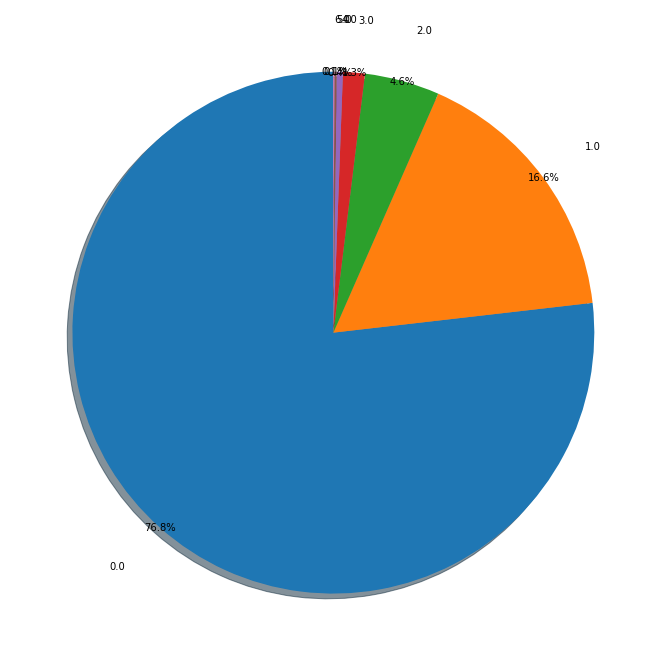

In [48]:
fig1, ax1 = plt.subplots(figsize = (12,12))
ax1.pie(train_df['number of tablets household owns'].value_counts().values,labels = train_df['number of tablets household owns'].value_counts().index, autopct='%1.1f%%',
        shadow=True, startangle=90,pctdistance=1, labeldistance=1.2)


#### Years behind in school

In [49]:
train_df.loc[:, train_df.isna().any()]['Years behind in school'].isna().value_counts()

KeyError: 'Years behind in school'

In [50]:
train_df.loc[:, train_df.isna().any()]['Years behind in school'].unique()

KeyError: 'Years behind in school'

In [51]:
# train_df = train_df.drop(columns=['Years behind in school'])

In [52]:
train_df['Years behind in school'] =  train_df['Years behind in school'].fillna(0)
# train_df['Years behind in school'].head()

KeyError: 'Years behind in school'

#### average years of education for adults (18+)	

In [53]:
set(train_df.loc[:, train_df.isna().any()]["average years of education for adults (18+)"].unique())

KeyError: 'average years of education for adults (18+)'

In [54]:
train_df[train_df["average years of education for adults (18+)"].isna()][["average years of education for adults (18+)",'Age in years','years of schooling']]

,average years of education for adults (18+),Age in years,years of schooling


In [55]:
error_index = train_df[train_df["average years of education for adults (18+)"].isna()][['Age in years','years of schooling']].index
for index in error_index:
    train_df["average years of education for adults (18+)"][index] = train_df.iloc[index,:]['years of schooling'] 

In [56]:
# train_df[train_df['Target']==4]["average years of education for adults (18+)"].mean()
# train_df["average years of education for adults (18+)"] =  train_df["average years of education for adults (18+)"].fillna(train_df[train_df['Target']==4]["average years of education for adults (18+)"].mean())
# train_df["average years of education for adults (18+)"].isna().sum()


#### meaned squared

In [57]:
train_df[train_df["meaned squared"].isna()]

,Household level identifier,Id,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 has toilet in the household,=1 if the household has refrigerator,owns a tablet,number of tablets household owns,...,escolari squared,age squared,hogar_total squared,edjefe squared,hogar_nin squared,overcrowding squared,dependency squared,meaned squared,Age squared,Target


In [58]:
error_index = train_df[train_df["meaned squared"].isna()][['Age in years','years of schooling']].index
for index in error_index:
    train_df["meaned squared"][index] = (train_df.iloc[index,:]['years of schooling'])**2

### Sorting "Yes" aand "No"

In [79]:
yes_no_columns = []
for i in range(len(train_df.columns)):
    value_list = train_df.iloc[:,i].unique()
    if 'yes' in value_list or 'no' in value_list:
        yes_no_columns.append(train_df.iloc[:,i].name)

/var/folders/fj/pkqhb62j0v35sdfyvpr9kd940000gn/T/ipykernel_35905/2192527565.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'yes' in value_list or 'no' in value_list:


In [80]:
yes_no_columns

['Dependency rate',
 'years of education of male head of household',
 'years of education of female head of household']

#### Dependecy

In [81]:
train_df['Dependency rate'].value_counts()

yes          2192
no           1747
.5           1497
2             730
1.5           713
.33333334     598
.66666669     487
8             378
.25           260
3             236
4             100
.75            98
.2             90
.40000001      84
1.3333334      84
2.5            77
5              24
1.25           18
3.5            18
.80000001      18
2.25           13
.71428573      12
1.75           11
1.2            11
.83333331      11
.22222222      11
.2857143        9
1.6666666       8
.60000002       8
6               7
.16666667       7
Name: Dependency rate, dtype: int64

In [82]:
train_df['dependency squared'].value_counts()

1.000000     2192
0.000000     1747
0.250000     1497
4.000000      730
2.250000      713
0.111111      598
0.444444      487
64.000000     378
0.062500      260
9.000000      236
16.000000     100
0.562500       98
0.040000       90
0.160000       84
1.777778       84
6.250000       77
25.000000      24
1.562500       18
12.250000      18
0.640000       18
5.062500       13
0.510204       12
3.062500       11
1.440000       11
0.694444       11
0.049383       11
0.081633        9
2.777778        8
0.360000        8
36.000000       7
0.027778        7
Name: dependency squared, dtype: int64

In [83]:
train_df['Dependency rate'] = np.sqrt(train_df['dependency squared'])

#### years of education of male head of household

In [85]:
# For male household heads
train_df[['years of education of male head of household', 'years of education of female head of household','edjefe squared']]

,years of education of male head of household,years of education of female head of household,edjefe squared
0,10,no,100
1,12,no,144
2,no,11,0
3,11,no,121
4,11,no,121
...,...,...,...
9552,9,no,81
9553,9,no,81
9554,9,no,81
9555,9,no,81


In [88]:
# For male household heads
train_df[['years of education of male head of household', 'years of education of female head of household','edjefe squared']][train_df['years of education of male head of household']=='no'][train_df['years of education of female head of household']=='no']

/var/folders/fj/pkqhb62j0v35sdfyvpr9kd940000gn/T/ipykernel_35905/650012708.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df[['years of education of male head of household', 'years of education of female head of household','edjefe squared']][train_df['years of education of male head of household']=='no'][train_df['years of education of female head of household']=='no']


,years of education of male head of household,years of education of female head of household,edjefe squared
86,no,no,0
87,no,no,0
121,no,no,0
122,no,no,0
123,no,no,0
...,...,...,...
9482,no,no,0
9490,no,no,0
9506,no,no,0
9550,no,no,0


In [89]:
# For male household heads
train_df[['years of education of male head of household', 'years of education of female head of household','edjefe squared']][train_df['years of education of male head of household']=='yes'][train_df['years of education of female head of household']=='no']

/var/folders/fj/pkqhb62j0v35sdfyvpr9kd940000gn/T/ipykernel_35905/2422900199.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df[['years of education of male head of household', 'years of education of female head of household','edjefe squared']][train_df['years of education of male head of household']=='yes'][train_df['years of education of female head of household']=='no']


,years of education of male head of household,years of education of female head of household,edjefe squared
601,yes,no,1
602,yes,no,1
2392,yes,no,1
2393,yes,no,1
2394,yes,no,1
...,...,...,...
9416,yes,no,1
9417,yes,no,1
9463,yes,no,1
9464,yes,no,1


In [87]:
# For Female household heads
train_df[['years of education of male head of household', 'years of education of female head of household','years of schooling','=1 if household head']][train_df['years of education of female head of household']=='no']

,years of education of male head of household,years of education of female head of household,years of schooling,=1 if household head
0,10,no,10,1
1,12,no,12,1
3,11,no,9,0
4,11,no,11,0
5,11,no,11,1
...,...,...,...,...
9552,9,no,9,1
9553,9,no,0,0
9554,9,no,5,0
9555,9,no,11,0


In [777]:
# For Female household heads
train_df[['years of education of male head of household', 'years of education of female head of household','years of schooling','=1 if household head']][train_df['years of education of female head of household']=='yes'][train_df['=1 if household head']==1]

/var/folders/fj/pkqhb62j0v35sdfyvpr9kd940000gn/T/ipykernel_70282/3641336463.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df[['years of education of male head of household', 'years of education of female head of household','years of schooling','=1 if household head']][train_df['years of education of female head of household']=='yes'][train_df['=1 if household head']==1]


,years of education of male head of household,years of education of female head of household,years of schooling,=1 if household head
432,no,yes,1,1
568,no,yes,1,1
595,no,yes,1,1
976,no,yes,1,1
1574,no,yes,1,1
2464,no,yes,1,1
2614,no,yes,1,1
3469,no,yes,1,1
3855,no,yes,1,1
3952,no,yes,1,1


edjefe squared is the squared value of 'years of education of male head of household' and it is equals to 0 when the household head is female. Likewise, 'years of education of female head of household' id no when household head is male

* 'edjefe' and 'edjefa' are both 'no' when the head of the household had 0 years of school
* there's 'edjefe'= 'yes' and 'edjefa'='no' in some cases, all these cases the head of the household had 1 year of school
* there's 'edjefe'= 'no' and 'edjefa'='yes' in some cases, all these cases the head of the household had 1 year of school
* most of the time either 'edjefe' or 'edjefa' is a number while the other is a 'no'

In [778]:
# Merge to form a single column "Years of education of head of household"
new_col_values = []
for row in range(len(train_df)):
    male_value = train_df.iloc[row,:]['years of education of male head of household']
    female_value = train_df.iloc[row,:]['years of education of female head of household']
    if (male_value =='no' and female_value=='no'): # Both No
        new_col_values.append(0)
    elif (male_value =='yes' and female_value=='no'): # one yes
        new_col_values.append(1)
    elif (male_value =='no' and female_value=='yes'): # one yes
        new_col_values.append(1)
    elif (male_value !='no' and male_value !='yes' and female_value=='no'): # male is a number
        new_col_values.append(male_value)
    else:
        new_col_values.append(female_value)# female is a number

In [779]:
train_df["Years of education of head of household"] = new_col_values

In [780]:
train_df[['years of education of male head of household', 'years of education of female head of household','Years of education of head of household']]

,years of education of male head of household,years of education of female head of household,Years of education of head of household
0,10,no,10
1,12,no,12
2,no,11,11
3,11,no,11
4,11,no,11
...,...,...,...
9552,9,no,9
9553,9,no,9
9554,9,no,9
9555,9,no,9


In [781]:
train_df['Years of education of head of household'].value_counts()

6     2792
11    1150
9      723
8      474
15     473
3      459
0      435
7      413
5      398
14     328
17     278
2      278
4      273
16     247
10     207
1      192
12     185
13     155
21      48
18      22
19      18
20       9
Name: Years of education of head of household, dtype: int64

In [782]:
train_df.drop(['years of education of male head of household', 'years of education of female head of household'], axis=1, inplace=True)

In [783]:
train_df.head()

,Household level identifier,Id,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 has toilet in the household,=1 if the household has refrigerator,owns a tablet,number of tablets household owns,...,age squared,hogar_total squared,edjefe squared,hogar_nin squared,overcrowding squared,dependency squared,meaned squared,Age squared,Target,Years of education of head of household
0,21eb7fcc1,ID_279628684,190000.0,0,3,0,1,1,0,0.0,...,1849,1,100,0,1.000000,0.0,100.0,1849,4,10
1,0e5d7a658,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,...,4489,1,144,0,1.000000,64.0,144.0,4489,4,12
2,2c7317ea8,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,...,8464,1,0,0,0.250000,64.0,121.0,8464,4,11
3,2b58d945f,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,...,289,16,121,4,1.777778,1.0,121.0,289,4,11
4,2b58d945f,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,...,1369,16,121,4,1.777778,1.0,121.0,1369,4,11


In [790]:
column_headers = list(train_df.columns)
column_headers.remove('Target')
column_headers.append('Target')
train_df=train_df[column_headers]
train_df.to_csv('train_df_renamed_new.csv', index=False)

In [984]:
# train_df = pd.read_csv('train_df_renamed_new.csv')

### Converting one hot ecoded variables into numeric

In [985]:
train_df.head()

,Household level identifier,Id,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 has toilet in the household,=1 if the household has refrigerator,owns a tablet,number of tablets household owns,...,age squared,hogar_total squared,edjefe squared,hogar_nin squared,overcrowding squared,dependency squared,meaned squared,Age squared,Years of education of head of household,Target
0,21eb7fcc1,ID_279628684,190000.0,0,3,0,1,1,0,0.0,...,1849,1,100,0,1.000000,0.0,100.0,1849,10,4
1,0e5d7a658,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,...,4489,1,144,0,1.000000,64.0,144.0,4489,12,4
2,2c7317ea8,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,...,8464,1,0,0,0.250000,64.0,121.0,8464,11,4
3,2b58d945f,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,...,289,16,121,4,1.777778,1.0,121.0,289,11,4
4,2b58d945f,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,...,1369,16,121,4,1.777778,1.0,121.0,1369,11,4


In [996]:
def get_numeric(one_df):
    new_col = []
    for row in range(len(one_df)):
        current_row = one_df.iloc[row,:]
        for col in range(len(current_row)):
            if current_row[col] == 1:
                new_col.append(col+1)
                break
            elif col == (len(current_row)-1):
                print("not_found")
                new_col.append(0)
    return new_col

#### Walls

In [997]:
walls = ["=1 if walls are bad","=1 if walls are regular","=1 if walls are good"]

In [998]:
train_df['wall_condition'] = get_numeric(train_df[walls])

In [999]:
train_df = train_df.drop(walls,axis = 1)

In [1000]:
train_df.head()

,Household level identifier,Id,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 has toilet in the household,=1 if the household has refrigerator,owns a tablet,number of tablets household owns,...,hogar_total squared,edjefe squared,hogar_nin squared,overcrowding squared,dependency squared,meaned squared,Age squared,Years of education of head of household,Target,wall_condition
0,21eb7fcc1,ID_279628684,190000.0,0,3,0,1,1,0,0.0,...,1,100,0,1.000000,0.0,100.0,1849,10,4,2
1,0e5d7a658,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,...,1,144,0,1.000000,64.0,144.0,4489,12,4,2
2,2c7317ea8,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,...,1,0,0,0.250000,64.0,121.0,8464,11,4,2
3,2b58d945f,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,...,16,121,4,1.777778,1.0,121.0,289,11,4,3
4,2b58d945f,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,...,16,121,4,1.777778,1.0,121.0,1369,11,4,3


#### Roofs

In [1001]:
roof = ["=1 if roof are bad","=1 if roof are regular","=1 if roof are good"]

In [1002]:
train_df['roof_condition'] = get_numeric(train_df[roof])

In [1003]:
train_df = train_df.drop(roof,axis = 1)

In [1004]:
train_df.head()

,Household level identifier,Id,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 has toilet in the household,=1 if the household has refrigerator,owns a tablet,number of tablets household owns,...,edjefe squared,hogar_nin squared,overcrowding squared,dependency squared,meaned squared,Age squared,Years of education of head of household,Target,wall_condition,roof_condition
0,21eb7fcc1,ID_279628684,190000.0,0,3,0,1,1,0,0.0,...,100,0,1.000000,0.0,100.0,1849,10,4,2,1
1,0e5d7a658,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,...,144,0,1.000000,64.0,144.0,4489,12,4,2,2
2,2c7317ea8,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,...,0,0,0.250000,64.0,121.0,8464,11,4,2,3
3,2b58d945f,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,...,121,4,1.777778,1.0,121.0,289,11,4,3,3
4,2b58d945f,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,...,121,4,1.777778,1.0,121.0,1369,11,4,3,3


#### floors

In [1005]:
floor = ["=1 if floor are bad","=1 if floor are regular","=1 if floor are good"]

In [1006]:
train_df['floor_condition'] = get_numeric(train_df[floor])

In [1007]:
train_df = train_df.drop(floor,axis = 1)

In [1008]:
train_df.head()

,Household level identifier,Id,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 has toilet in the household,=1 if the household has refrigerator,owns a tablet,number of tablets household owns,...,hogar_nin squared,overcrowding squared,dependency squared,meaned squared,Age squared,Years of education of head of household,Target,wall_condition,roof_condition,floor_condition
0,21eb7fcc1,ID_279628684,190000.0,0,3,0,1,1,0,0.0,...,0,1.000000,0.0,100.0,1849,10,4,2,1,1
1,0e5d7a658,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,...,0,1.000000,64.0,144.0,4489,12,4,2,2,2
2,2c7317ea8,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,...,0,0.250000,64.0,121.0,8464,11,4,2,3,3
3,2b58d945f,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,...,4,1.777778,1.0,121.0,289,11,4,3,3,3
4,2b58d945f,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,...,4,1.777778,1.0,121.0,1369,11,4,3,3,3


#### Education level

In [1009]:
edu_level = ["instlevel{}".format(i) for i in range(1,10)]
edu_level = list(np.ravel(feature_description.loc[edu_level].values))

In [1010]:
train_df[edu_level]

,=1 no level of education,=1 incomplete primary,=1 complete primary,=1 incomplete academic secondary level,=1 complete academic secondary level,=1 incomplete technical secondary level,=1 complete technical secondary level,=1 undergraduate and higher education,=1 postgraduate higher education
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
9552,0,0,0,1,0,0,0,0,0
9553,1,0,0,0,0,0,0,0,0
9554,0,1,0,0,0,0,0,0,0
9555,0,0,0,0,1,0,0,0,0


In [1011]:
train_df['education_level'] = get_numeric(train_df[edu_level])

not_found
not_found
not_found


In [1013]:
train_df = train_df.drop(edu_level,axis = 1)

In [1014]:
train_df.head()

,Household level identifier,Id,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 has toilet in the household,=1 if the household has refrigerator,owns a tablet,number of tablets household owns,...,overcrowding squared,dependency squared,meaned squared,Age squared,Years of education of head of household,Target,wall_condition,roof_condition,floor_condition,education_level
0,21eb7fcc1,ID_279628684,190000.0,0,3,0,1,1,0,0.0,...,1.000000,0.0,100.0,1849,10,4,2,1,1,4
1,0e5d7a658,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,...,1.000000,64.0,144.0,4489,12,4,2,2,2,8
2,2c7317ea8,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,...,0.250000,64.0,121.0,8464,11,4,2,3,3,5
3,2b58d945f,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,...,1.777778,1.0,121.0,289,11,4,3,3,3,4
4,2b58d945f,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,...,1.777778,1.0,121.0,1369,11,4,3,3,3,5


In [1093]:
feature_description.loc['tamviv']

Variable description    TamViv
Name: tamviv, dtype: object

### Removing Redundant

Delete needless columns

**redundant columns**

* r4t3, tamviv, tamhog, hhsize ... almost the same as hogar_total
* v14a ... almost the same as saniatrio1
* v18q, mobilephone ... can be generated by v18q1, qmobilephone
 SQBxxx, agesq ... squared values
* parentescoxxx ... only heads of household are in dataset now

**extra columns**

(One-hot variables should be linearly independent. For example, female (or male) column is needless, because whether the sample is female or not can be explained only with male (or female) column.)

* paredother, pisoother, abastaguano, energcocinar1, techootro, sanitario6, elimbasu6, estadocivil7, parentesco12, tipovivi5, lugar1, area1, female

**obsolete columns**
* epared1~3, etecho1~3, eviv1~3, instlevel1~9 ... we don't use these columns anymore.

In [1022]:
needless_cols = ['r4t3', 'tamhog', 'tamviv', 'hhsize', 'v18q', 'v14a', 'agesq',
                 'mobilephone', 'paredother', 'pisoother', 'abastaguano',
                 'energcocinar1', 'techootro', 'sanitario6', 'elimbasu6',
                 'estadocivil7', 'parentesco12', 'tipovivi5',
                 'lugar1', 'area1', 'female']
SQB_cols = [s for s in train_df.columns.tolist() if 'squared' in s]
needless_cols = list(np.ravel(feature_description.loc[needless_cols].values))
needless_cols = needless_cols + SQB_cols

In [1024]:
needless_cols

['Total persons in the household',
 'size of the household',
 'TamViv',
 'household size',
 'owns a tablet',
 '=1 has toilet in the household',
 'Age squared',
 '=1 if mobile phone',
 '=1 if predominant material on the outside wall is other',
 '=1 if predominant material on the floor is other',
 '=1 if no water provision',
 '=1 no main source of energy used for cooking (no kitchen)',
 '=1 if predominant material on the roof is other',
 '=1 toilet connected to other system',
 '=1 if rubbish disposal mainly other',
 '=1 if single',
 '=1 if other non family member',
 '=1 other(assigned, borrowed)',
 '=1 region Central',
 '=1 zona urbana',
 '=1 if female',
 'escolari squared',
 'age squared',
 'hogar_total squared',
 'edjefe squared',
 'hogar_nin squared',
 'overcrowding squared',
 'dependency squared',
 'meaned squared',
 'Age squared']

In [1025]:
train_df = train_df.drop(needless_cols,axis = 1)

In [1026]:
train_df.head()

,Household level identifier,Id,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 if the household has refrigerator,number of tablets household owns,Males younger than 12 years of age,Males 12 years of age and older,...,=1 region Huetar AtlÃƒÂ¡ntica,=1 region Huetar Norte,=2 zona rural,Age in years,Years of education of head of household,Target,wall_condition,roof_condition,floor_condition,education_level
0,21eb7fcc1,ID_279628684,190000.0,0,3,0,1,0.0,0,1,...,0,0,0,43,10,4,2,1,1,4
1,0e5d7a658,ID_f29eb3ddd,135000.0,0,4,0,1,1.0,0,1,...,0,0,0,67,12,4,2,2,2,8
2,2c7317ea8,ID_68de51c94,0.0,0,8,0,1,0.0,0,0,...,0,0,0,92,11,4,2,3,3,5
3,2b58d945f,ID_d671db89c,180000.0,0,5,0,1,1.0,0,2,...,0,0,0,17,11,4,3,3,3,4
4,2b58d945f,ID_d56d6f5f5,180000.0,0,5,0,1,1.0,0,2,...,0,0,0,37,11,4,3,3,3,5


In [1027]:
column_headers = list(train_df.columns)
column_headers.remove('Target')
column_headers.append('Target')
train_df=train_df[column_headers]
train_df.to_csv('train_df_renamed_new.csv', index=False)

### Others

In [ ]:
id = ['Id', 'Household level identifier', 'Target']

Dropping Column with no variance

In [ ]:
train_df['=1 if rubbish disposal mainly by throwing in river, creek or sea'].unique()

In [ ]:
train_df = train_df.drop(columns='=1 if rubbish disposal mainly by throwing in river, creek or sea')

In [ ]:
train_df_less_id = train_df.drop(columns = id)
# train_df_less_id.dropna()

In [ ]:
constant_filter = VarianceThreshold(threshold=0.01)
constant_filter.fit(train_df_less_id)

len(train_df_less_id.columns[constant_filter.get_support()])

qconstant_filter = [column for column in train_df_less_id.columns
                    if column not in train_df_less_id.columns[constant_filter.get_support()]]

qconstant_filter

In [ ]:
possible_removals = qconstant_filter


In [ ]:
len(qconstant_filter)

In [ ]:
fig, ax = plt.subplots(5, 5,figsize=(15,20))
j=0
for i in tq.tqdm(range(len(qconstant_filter))):
    if ((i+1)/5)>j+1:
        j+=1
#     print(f"j is {j} and i is {i} and division is {i%5}")
    ax[j,i%5].hist(train_df[qconstant_filter[i]])
    ax[j,i%5].set_title(qconstant_filter[i])
fig.tight_layout()

In [ ]:
no_variance = []
for i in range(len(train_df.columns)):
    value_list = train_df.iloc[:,i].unique()
    if len(value_list)<2:
        no_variance.append(train_df.iloc[:,i].name)

In [ ]:
# no_variance
train_df.head()

In [657]:
train_df.to_csv('train_df_renamed_new.csv', index=False)

## Sorting features

In [ ]:
# train_df = pd.read_csv("train_df_renamed.csv")

In [ ]:
train_df.head()

In [ ]:
id = ['Id', 'Household level identifier', 'Target']

In [ ]:
ind_bool = ['owns a tablet', '=1 if disable person', '=1 if male', '=1 if female', '=1 if less than 10 years old', '=1 if free or coupled uunion', '=1 if married', '=1 if divorced', '=1 if separated', '=1 if widow/er', '=1 if single', '=1 if household head', '=1 if spouse/partner', '=1 if son/doughter', '=1 if stepson/doughter', '=1 if son/doughter in law', '=1 if grandson/doughter', '=1 if mother/father', '=1 if father/mother in law', '=1 if brother/sister', '=1 if brother/sister in law', '=1 if other family member', '=1 if other non family member', '=1 no level of education', '=1 incomplete primary', '=1 complete primary', '=1 incomplete academic secondary level', '=1 complete academic secondary level', '=1 incomplete technical secondary level', '=1 complete technical secondary level', '=1 undergraduate and higher education', '=1 postgraduate higher education', '=1 if mobile phone']

ind_ordered = ['years of schooling', 'Age in years']


In [ ]:
hh_bool = ['=1 Overcrowding by bedrooms', '=1 Overcrowding by rooms', '=1 has toilet in the household', '=1 if the household has refrigerator', '=1 if predominant material on the outside wall is block or brick', '=1 if predominant material on the outside wall is socket (wood, zinc or absbesto', '=1 if predominant material on the outside wall is prefabricated or cement', '=1 if predominant material on the floor is cement', '=1 if predominant material on the outside wall is waste material', '=1 if predominant material on the outside wall is wood ', '=1 if predominant material on the outside wall is zink', '=1 if predominant material on the outside wall is natural fibers', '=1 if predominant material on the outside wall is other', '=1 if predominant material on the floor is mosaic, ceramic, terrazo', '=1 if predominant material on the floor is other', '=1 if predominant material on the floor is  natural material', '=1 if no floor at the household', '=1 if predominant material on the floor is wood', '=1 if predominant material on the roof is metal foil or zink', '=1 if predominant material on the roof is fiber cement, mezzanine ', '=1 if predominant material on the roof is natural fibers', '=1 if predominant material on the roof is other', '=1 if the house has ceiling', '=1 if water provision inside the dwelling', '=1 if water provision outside the dwelling', '=1 if no water provision', '=1 electricity from CNFL, ICE, ESPH/JASEC', '=1 electricity from private plant', '=1 no electricity in the dwelling', '=1 electricity from cooperative', '=1 no toilet in the dwelling', '=1 toilet connected to sewer or cesspool', '=1 toilet connected to  septic tank', '=1 toilet connected to black hole or letrine', '=1 toilet connected to other system', '=1 no main source of energy used for cooking (no kitchen)', '=1 main source of energy used for cooking electricity', '=1 main source of energy used for cooking gas', '=1 main source of energy used for cooking wood charcoal', '=1 if rubbish disposal mainly by tanker truck', '=1 if rubbish disposal mainly by botan hollow or buried', '=1 if rubbish disposal mainly by burning', '=1 if rubbish disposal mainly by throwing in an unoccupied space', '=1 if rubbish disposal mainly other', '=1 if walls are bad', '=1 if walls are regular', '=1 if walls are good', '=1 if roof are bad', '=1 if roof are regular', '=1 if roof are good', '=1 if floor are bad', '=1 if floor are regular', '=1 if floor are good', '=1 own and fully paid house', '=1 own, paying in installments', '=1 rented', '=1 precarious', '=1 other(assigned, borrowed)', '=1 if the household has notebook or desktop computer', '=1 if the household has TV', '=1 region Central', '=1 region Chorotega', '=1 region PacÃƒÂ\xadfico central', '=1 region Brunca', '=1 region Huetar AtlÃƒÂ¡ntica', '=1 region Huetar Norte', '=1 zona urbana', '=2 zona rural']

hh_ordered = [' number of all rooms in the house', 'Males younger than 12 years of age', 'Males 12 years of age and older', 'Total males in the household', 'Females younger than 12 years of age', 'Females 12 years of age and older', 'Total females in the household', 'persons younger than 12 years of age', 'persons 12 years of age and older', 'Total persons in the household', 'number of tablets household owns', 'size of the household', 'TamViv', 'household size', 'Number of children 0 to 19 in household', 'Number of adults in household', '# of individuals 65+ in the household', '# of total individuals in the household', 'number of bedrooms', '# of mobile phones']

hh_cont = ['Monthly rent payment', 'Dependency rate', 'years of education of male head of household', 'years of education of female head of household', 'average years of education for adults (18+)', '# persons per room']

In [ ]:
sqr_values = ['escolari squared', 'age squared', 'hogar_total squared', 'edjefe squared', 'hogar_nin squared', 'overcrowding squared', 'dependency squared', 'meaned squared', 'Age squared']

In [ ]:
sum_col = len(id)+len(ind_bool)+len(ind_ordered)+len(hh_bool)+len(hh_ordered)+len(hh_cont)+len(sqr_values)
print(f"Len of train is {len(train_df.columns)}")
print(f"Len of added columns is {sum_col}")

In [ ]:
ind_bool_df = train_df[ind_bool]
ind_ordered_df = train_df[ind_ordered]
hh_bool_df = train_df[hh_bool]
hh_ordered_df = train_df[hh_ordered]
hh_cont_df = train_df[hh_cont]
sqr_values = train_df[sqr_values]

#### Individual level

In [ ]:
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(32, 24))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(ind_bool_df.corr(), dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
plt.title("Correlation Heatmap for Individual level data",fontsize=24)
#
sns.heatmap(ind_bool_df.corr(), annot=True, mask = mask, cmap=cmap)

In [ ]:
household_df = train_df.loc[train_df['=1 if household head'] == 1, :]
household_df = household_df[ind_bool + ind_ordered]
household_df.shape

In [ ]:
# Create correlation matrix
corr_matrix = household_df.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
highly_correlated = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

highly_correlated

In [ ]:
# Information is directly inverse of that of 'if male'
to_drop = ['=1 if female']
possible_removals = possible_removals + to_drop

#### HH level variables

In [ ]:
household_df = train_df.loc[train_df['=1 if household head'] == 1, :]
household_df = household_df[hh_bool + hh_cont + hh_ordered]
household_df.shape

In [ ]:
# Create correlation matrix
corr_matrix = household_df.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
highly_correlated = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

highly_correlated

In [ ]:

# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(12, 6))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(train_df[highly_correlated].corr(), dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(train_df[highly_correlated].corr(), annot=True, cmap=cmap)

In [ ]:
to_drop = ['household size', '# of total individuals in the household']
possible_removals = possible_removals + to_drop

### Possible removals

In [ ]:
set(possible_removals)

# Machine Learning Testing

In [1029]:
train_df = pd.read_csv("train_df_renamed_new.csv")
train_df = train_df.drop(columns = ['Household level identifier','Id'])
train_df.head()

,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 if the household has refrigerator,number of tablets household owns,Males younger than 12 years of age,Males 12 years of age and older,Total males in the household,Females younger than 12 years of age,...,=1 region Huetar AtlÃƒÂ¡ntica,=1 region Huetar Norte,=2 zona rural,Age in years,Years of education of head of household,wall_condition,roof_condition,floor_condition,education_level,Target
0,190000.0,0,3,0,1,0.0,0,1,1,0,...,0,0,0,43,10,2,1,1,4,4
1,135000.0,0,4,0,1,1.0,0,1,1,0,...,0,0,0,67,12,2,2,2,8,4
2,0.0,0,8,0,1,0.0,0,0,0,0,...,0,0,0,92,11,2,3,3,5,4
3,180000.0,0,5,0,1,1.0,0,2,2,1,...,0,0,0,17,11,3,3,3,4,4
4,180000.0,0,5,0,1,1.0,0,2,2,1,...,0,0,0,37,11,3,3,3,5,4


## Helper Functions

In [1066]:
#need to normalise some of the columns
def prepData(df,test_size = 0.3,normalize = True,include_eval = False):
    unnormal_cols = selectUnnormalised(df)
    x = df.iloc[:, :-1]
    y = df.iloc[:, -1:] - 1 
    xtrain, xtest, ytrain, ytest = tts(x,y,test_size = test_size, random_state = 42)
    if include_eval:
        xtest, x_eval, ytest, y_eval = tts(xtest,ytest,test_size = 0.1/0.3, random_state = 42)
        return xtrain.values, xtest.values, x_eval.values, ytrain, ytest, y_eval
    else:
        if normalize:
            xTrain, xTest = normalise(unnormal_cols, xtrain, xtest)
            yTrain, yTest = ytrain.values.ravel(), ytest.values.ravel()
            return xTrain, xTest, yTrain, yTest
        return xtrain.values, xtest.values, ytrain, ytest
    
    
    

#getting the columns with non-normalised values
def selectUnnormalised(df):
    normCol = df.columns[df.isin([0,1]).all()] #getting the binary columns
    dfCols_list = list(df.columns)
    unnormCols = list(set(dfCols_list)-set(normCol))
    
    #remove target because we shouldn't normalise that, but rather encode
    unnormCols.remove('Target')
    return unnormCols

#normalising data in training set
def normalise(unnormCols, xTrain, xTest):
    #normalise training data
    toBeNorm_train = xTrain[[i for i in unnormCols]]
    ss = StandardScaler()
    std_scale = ss.fit(toBeNorm_train)
    xTrain_norm = std_scale.transform(toBeNorm_train)
    
    #covert numpy array to df
    xTrain_normCol = pd.DataFrame(xTrain_norm, index = toBeNorm_train.index,
                                 columns = toBeNorm_train.columns)
    xTrain.update(xTrain_normCol)
    
    #normalise test data using mean and SD of training set
    toBeNorm_test = xTest[[i for i in unnormCols]]
    xTest_norm = std_scale.transform(toBeNorm_test)
    xTest_normCol = pd.DataFrame(xTest_norm, index = toBeNorm_test.index,
                                columns = toBeNorm_test.columns)
    xTest.update(xTest_normCol)
    
    return xTrain, xTest



In [465]:
# xtrain, xtest, x_eval, ytrain, ytest, y_eval = prepData(train_df,normalize=False,include_eval = True)

In [466]:
# datasets = [xtrain, xtest, x_eval, ytrain, ytest, y_eval]
# for i in datasets:
#     print(f"Len is {len(i)}")

Len is 6689
Len is 1911
Len is 957
Len is 6689
Len is 1911
Len is 957


In [869]:
# xtrain, xtest, ytrain, ytest = prepData(train_df,normalize=False)
xtrain, xtest, ytrain, ytest = prepData(train_df,test_size = 0.1)

## LightGBM

In [872]:
# build the model
lgb_clf = lgb.LGBMClassifier(max_depth=-1, learning_rate=0.03, objective='multiclass',
                             random_state=None, silent=True, metric='multi_logloss', 
                             n_jobs=4, n_estimators=5000, class_weight='balanced',
                             colsample_bytree =  0.89, min_child_samples = 90, num_leaves = 56, subsample = 0.96)

# fit data into the model and predict the test set
lgb_clf.fit(xtrain.values, ytrain, eval_set=[(xtest.values, ytest)], 
            early_stopping_rounds=400, verbose=100)
y_pred = lgb_clf.predict(xtest)

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

[100]	valid_0's multi_logloss: 0.556086
[200]	valid_0's multi_logloss: 0.341397
[300]	valid_0's multi_logloss: 0.23718
[400]	valid_0's multi_logloss: 0.180337
[500]	valid_0's multi_logloss: 0.151489
[600]	valid_0's multi_logloss: 0.136319
[700]	valid_0's multi_logloss: 0.1319
[800]	valid_0's multi_logloss: 0.13262
[900]	valid_0's multi_logloss: 0.136766
[1000]	valid_0's multi_logloss: 0.142303


In [876]:
cm = confusion_matrix(ytest, y_pred)
f1 = f1_score(ytest, y_pred, average='macro')
print("confusion matrix: \n", cm)
# print("macro F1 score: \n", f1)
print("Classification accuracy: {:.2f}".format(lgb_clf.score(xtest, ytest)))
print("F1 score : {:.2f}".format(f1_score(ytest, y_pred, average = 'macro')))

confusion matrix: 
 [[ 77   1   0   1]
 [  0 148   3   5]
 [  0   2 120   9]
 [  0   7   5 578]]
Classification accuracy: 0.97
F1 score : 0.96


In [878]:
final_df = copy.deepcopy(xtest)
final_df['Target'] = ytest
final_df['Pred'] = y_pred
final_df

,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 has toilet in the household,=1 if the household has refrigerator,owns a tablet,number of tablets household owns,Males younger than 12 years of age,Males 12 years of age and older,...,hogar_total squared,edjefe squared,hogar_nin squared,overcrowding squared,dependency squared,meaned squared,Age squared,Years of education of head of household,Target,Pred
8503,-0.421354,0,-0.652043,0,1,1,0,-0.467602,-0.571187,-1.506516,...,-0.967108,-0.679713,-0.555631,-0.722963,-0.312299,-0.708219,1.116875,-0.450839,1,1
7752,-0.421354,0,-0.652043,0,1,1,0,-0.467602,-0.571187,0.426580,...,0.894454,-0.565009,1.760820,1.383382,0.007169,1.988735,-0.667071,-1.133406,0,0
9350,-0.421354,0,-0.652043,0,1,1,0,-0.467602,0.901028,0.426580,...,-0.169296,-0.628734,0.023482,-0.355189,-0.232432,-0.961392,-0.897793,-1.360929,0,0
8414,-0.421354,0,0.026590,0,1,1,0,-0.467602,0.901028,-0.539968,...,-0.541608,-0.679713,-0.410853,-0.542420,-0.292333,-0.708219,0.164216,-0.450839,2,2
7671,-0.421354,0,0.026590,0,1,1,0,-0.467602,0.901028,-0.539968,...,0.894454,0.862416,3.063824,0.179756,1.684378,3.609040,-0.886916,0.686773,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,-0.421354,0,1.383856,0,1,1,0,-0.467602,-0.571187,1.393128,...,0.894454,0.594774,-0.410853,0.179756,-0.309105,0.293385,-0.428906,0.459251,3,3
1982,2.215327,0,0.026590,0,1,1,1,3.823125,-0.571187,0.426580,...,-0.169296,1.818282,0.023482,-0.355189,-0.232432,1.149268,-0.815352,1.369341,3,3
4387,0.285800,0,-1.330676,0,1,1,0,-0.467602,0.901028,-0.539968,...,-0.169296,0.135959,0.023482,0.179756,-0.232432,-0.228524,-0.357915,0.004206,3,3
5489,-0.421354,0,0.026590,0,1,1,0,-0.467602,-0.571187,0.426580,...,-0.169296,-0.220898,-0.555631,-0.355189,-0.312299,-0.492356,1.116875,-0.450839,3,3


In [880]:
final_hh_df = final_df[final_df["=1 if household head"]==1]
# print("Classification accuracy: {:.2f}".format(lgb_clf.score(xtest, ytest)))
print("F1 score : {:.2f}".format(f1_score(final_hh_df['Target'].values, final_hh_df['Pred'].values, average = 'macro')))

F1 score : 0.90


### Just household heads

In [1067]:
train_hh_df = train_df[train_df["=1 if household head"]==1]

In [1068]:
train_hh_df = train_hh_df.drop("=1 if household head",axis =1)

In [1069]:
train_hh_df.head()

,Monthly rent payment,=1 Overcrowding by bedrooms,number of all rooms in the house,=1 Overcrowding by rooms,=1 if the household has refrigerator,number of tablets household owns,Males younger than 12 years of age,Males 12 years of age and older,Total males in the household,Females younger than 12 years of age,...,=1 region Huetar AtlÃƒÂ¡ntica,=1 region Huetar Norte,=2 zona rural,Age in years,Years of education of head of household,wall_condition,roof_condition,floor_condition,education_level,Target
0,190000.0,0,3,0,1,0.0,0,1,1,0,...,0,0,0,43,10,2,1,1,4,4
1,135000.0,0,4,0,1,1.0,0,1,1,0,...,0,0,0,67,12,2,2,2,8,4
2,0.0,0,8,0,1,0.0,0,0,0,0,...,0,0,0,92,11,2,3,3,5,4
5,180000.0,0,5,0,1,1.0,0,2,2,1,...,0,0,0,38,11,3,3,3,5,4
8,130000.0,1,2,0,1,0.0,0,1,1,2,...,0,0,0,30,9,1,1,2,4,4


In [1070]:
import re
train_hh_df = train_hh_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [1071]:
xTrain, xTest, yTrain, yTest = prepData(train_hh_df,test_size = 0.3)

In [1072]:
xTrain

,Monthlyrentpayment,1Overcrowdingbybedrooms,numberofallroomsinthehouse,1Overcrowdingbyrooms,1ifthehouseholdhasrefrigerator,numberoftabletshouseholdowns,Malesyoungerthan12yearsofage,Males12yearsofageandolder,Totalmalesinthehousehold,Femalesyoungerthan12yearsofage,...,1regionBrunca,1regionHuetarAtlntica,1regionHuetarNorte,2zonarural,Ageinyears,Yearsofeducationofheadofhousehold,wall_condition,roof_condition,floor_condition,education_level
1832,1.110319,0,-0.542585,0,1,-0.463415,-0.479945,-1.425525,-1.488300,-0.465538,...,0,0,0,0,-0.505203,1.712411,0.745323,0.749505,0.656544,1.673347
8912,0.108776,0,-0.542585,0,1,-0.463415,1.362796,-0.306507,0.451664,-0.465538,...,0,0,1,0,0.059083,-0.043129,0.745323,0.749505,0.656544,-0.113789
5006,-0.409264,0,0.151830,0,1,-0.463415,-0.479945,-1.425525,-1.488300,-0.465538,...,0,0,0,1,-1.132187,1.712411,0.745323,0.749505,0.656544,1.673347
4475,-0.409264,0,0.846246,0,1,-0.463415,-0.479945,-0.306507,-0.518318,-0.465538,...,0,0,0,0,1.438449,1.712411,0.745323,0.749505,0.656544,1.673347
5214,0.972175,0,0.846246,0,1,-0.463415,-0.479945,0.812511,0.451664,-0.465538,...,0,0,0,1,-0.379806,-0.482014,0.745323,0.749505,0.656544,-0.560573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5250,-0.409264,0,-0.542585,0,1,-0.463415,1.362796,-0.306507,0.451664,1.283170,...,0,0,0,1,-0.944092,1.712411,-0.750354,-0.654383,-0.882047,1.673347
3437,-0.409264,0,1.540662,0,1,1.072201,-0.479945,-0.306507,-0.518318,-0.465538,...,0,0,0,0,0.497972,0.176313,0.745323,0.749505,0.656544,-0.113789
3576,-0.409264,0,-0.542585,0,1,-0.463415,-0.479945,-0.306507,-0.518318,-0.465538,...,0,0,0,0,0.247178,-0.482014,0.745323,0.749505,0.656544,-0.560573
4127,-0.409264,0,0.151830,0,1,-0.463415,-0.479945,0.812511,0.451664,-0.465538,...,0,0,0,0,0.686067,-0.482014,0.745323,-0.654383,0.656544,-0.560573


In [1090]:
F1_scorer = make_scorer(f1_score, greater_is_better=True, average='macro')

gbm_param = {
    'num_leaves':[210]
    ,'min_data_in_leaf':[9]
    ,'max_depth':[14]
}
gbm = GridSearchCV(
    lgb.LGBMClassifier(objective='multiclassova', class_weight='balanced', seed=0)
    , gbm_param
    , scoring=F1_scorer
)


# params = {'num_leaves': 13, 'min_data_in_leaf': 23, 'max_depth': 11, 'learning_rate': 0.09, 'feature_fraction': 0.74}
# gbm = lgb.LGBMClassifier(boosting_type='dart', objective='multiclassova', class_weight='balanced', random_state=0)
# gbm.set_params(**params)

gbm.fit(xTrain.values, yTrain)
# gbm.best_params_

[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


GridSearchCV(estimator=LGBMClassifier(class_weight='balanced',
                                      objective='multiclassova', seed=0),
             param_grid={'max_depth': [14], 'min_data_in_leaf': [9],
                         'num_leaves': [210]},
             scoring=make_scorer(f1_score, average=macro))

In [1078]:
# build the model
lgb_clf = lgb.LGBMClassifier(max_depth=-1, learning_rate=0.03, objective='multiclass',
                             random_state=None, silent=True, metric='multi_logloss', 
                             n_jobs=4, n_estimators=5000, class_weight='balanced',
                             colsample_bytree =  0.89, min_child_samples = 90, num_leaves = 56, subsample = 0.96)


# fit data into the model and predict the test set
lgb_clf.fit(xTrain.values, yTrain, eval_set=[(xTest.values, yTest)], 
            early_stopping_rounds=400, verbose=100)
yPred = lgb_clf.predict(xTest)

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

[100]	valid_0's multi_logloss: 1.03757
[200]	valid_0's multi_logloss: 1.0127
[300]	valid_0's multi_logloss: 0.999112
[400]	valid_0's multi_logloss: 0.993283
[500]	valid_0's multi_logloss: 1.0049
[600]	valid_0's multi_logloss: 1.02145
[700]	valid_0's multi_logloss: 1.04227


In [1079]:
cm = confusion_matrix(yTest, yPred)
f1 = f1_score(yTest, yPred, average='macro')
print("confusion matrix: \n", cm)
print("macro F1 score: \n", f1)
print("Classification accuracy: {:.2f}".format(lgb_clf.score(xTest, yTest)))
# print("F1 score : {}".format(f1_score(ytest.values, y_pred, average = 'macro')))

confusion matrix: 
 [[ 29  19   9  11]
 [ 27  54  29  30]
 [ 13  23  29  43]
 [ 27  60  65 424]]
macro F1 score: 
 0.43561947274878154
Classification accuracy: 0.60


In [1073]:
from sklearn.metrics import f1_score
def evaluate_macroF1_lgb(truth, predictions):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True) 

import lightgbm as lgb
fit_params={"early_stopping_rounds":300, 
            "eval_metric" : evaluate_macroF1_lgb, 
            "eval_set" : [(xTest,yTest)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': False,
            'categorical_feature': 'auto'}

def learning_rate_power_0997(current_iter):
    base_learning_rate = 0.1
    min_learning_rate = 0.02
    lr = base_learning_rate  * np.power(.995, current_iter)
    return max(lr, min_learning_rate)

fit_params['callbacks'] = [lgb.reset_parameter(learning_rate=learning_rate_power_0997)]

In [1074]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(12, 20), 
             'min_child_samples': sp_randint(40, 100), 
             #'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.75, scale=0.25), 
             'colsample_bytree': sp_uniform(loc=0.8, scale=0.15)#,
             #'reg_alpha': [0, 1e-3, 1e-1, 1, 10, 50, 100],
             #'reg_lambda': [0, 1e-3, 1e-1, 1, 10, 50, 100]
            }

In [1075]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
clf = lgb.LGBMClassifier(max_depth=-1, learning_rate=0.05, objective='multiclass',
                         random_state=314, silent=True, metric='None', 
                         n_jobs=4, n_estimators=5000, class_weight='balanced')

gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='f1_macro',
    cv=5,
    refit=True,
    random_state=314,
    verbose=True)

In [1076]:
_ = gs.fit(xTrain, yTrain, **fit_params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

In [1077]:
opt_parameters = gs.best_params_
clf_final = lgb.LGBMClassifier(**clf.get_params())
clf_final.set_params(**opt_parameters)

def learning_rate_power_0997(current_iter):
    base_learning_rate = 0.1
    min_learning_rate = 0.02
    lr = base_learning_rate  * np.power(.997, current_iter)
    return max(lr, min_learning_rate)

#Train the final model with learning rate decay
fit_params['verbose'] = 200

_ = clf_final.fit(xTrain.values, yTrain, **fit_params)#, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_power_0997)])

/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future releas

[200]	valid's macroF1: 0.42937
[400]	valid's macroF1: 0.433518
